In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt

import CustomMetrics
import EnergyPricesLibrary as Ep

%load_ext autoreload
%autoreload 2

In [2]:
def build_model_I2(hourly_input_shape,n_steps_out=24):
    
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            input_shape=hourly_input_shape,
            units=320,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.0975),
            dropout=0.27,
            return_sequences=True
        )
    )

    model.add(
        tf.keras.layers.LSTM(   
            units=448,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.03),
            dropout=0.36,
            return_sequences=False
        )
    )

    model.add(tf.keras.layers.Dense(units=n_steps_out,activation=None))

    model.compile(
        optimizer=tf.optimizers.Adam(0.0002),
        loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
        metrics=[tf.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(),
                 CustomMetrics.symmetric_mean_absolute_percentage_error]
    )
    
    return model

In [3]:
def build_model_I3(hourly_input_shape,n_steps_out=24):
    
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.LSTM(
            input_shape=hourly_input_shape,
            units=128,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),
            dropout=0.09,
            return_sequences=True
        )
    )

    model.add(
        tf.keras.layers.LSTM(   
            units=384,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.0225),
            dropout=0,
            return_sequences=False
        )
    )

    model.add(tf.keras.layers.Dense(units=n_steps_out,activation=None))

    model.compile(
        optimizer=tf.optimizers.Adam(0.000103025),
        loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
        metrics=[tf.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(),
                 CustomMetrics.symmetric_mean_absolute_percentage_error]
    )
    
    return model

In [4]:
def build_model_I5(hourly_input_shape,n_steps_out=24):
    
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.GRU(
            input_shape=hourly_input_shape,
            units=448,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.06),
            dropout=0.36,
            return_sequences=True
        )
    )

    model.add(
        tf.keras.layers.GRU(   
            units=128,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.09),
            dropout=0.36,
            return_sequences=False
        )
    )

    model.add(tf.keras.layers.Dense(units=n_steps_out,activation=None))

    model.compile(
        optimizer=tf.optimizers.Adam(0.00027),
        loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
        metrics=[tf.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(),
                 CustomMetrics.symmetric_mean_absolute_percentage_error]
    )
    
    return model

In [5]:
def build_model_I15(hourly_input_shape,n_steps_out=24):
    
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.GRU(
            input_shape=hourly_input_shape,
            units=448,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.0975),
            dropout=0.54,
            return_sequences=False
        )
    )

    model.add(tf.keras.layers.Dense(units=72,activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0))
    model.add(tf.keras.layers.Dense(units=n_steps_out,activation=None))

    model.compile(
        optimizer=tf.optimizers.Adam(0.00101),
        loss=CustomMetrics.symmetric_mean_absolute_percentage_error,
        metrics=[tf.metrics.MeanAbsoluteError(),
                 tf.keras.metrics.MeanAbsolutePercentageError(),
                 CustomMetrics.symmetric_mean_absolute_percentage_error]
    )
    
    return model

In [6]:
def make_predictions(model,scaler_y,trainX,trainY,testX,testY,n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict(trainX)
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict(testX)
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_y.inverse_transform(trainPredict)
    trainY_ = scaler_y.inverse_transform(trainY.reshape(trainY.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_y.inverse_transform(testPredict)
    testY_ = scaler_y.inverse_transform(testY.reshape(testY.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY_,testPredict,testY_

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    testMAPE  = Ep.MAPE(testPredict,testY)
    
    train_sMAPE  = Ep.sMAPE(trainY,trainPredict)
    test_sMAPE  = Ep.sMAPE(testY,testPredict)
    
    return trainMAPE,testMAPE,train_sMAPE,test_sMAPE

# DATASET

## Load Dataset

In [7]:
data_horaria_path = os.path.join('dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [8]:
precio_bolsa_path = os.path.join('dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [9]:
nombre_series_horaria = data_horaria.columns

In [10]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)
data_horaria_full.shape,data_horaria.shape,precio_bolsa.shape

((177480, 86), (177480, 85), (177480, 1))

## Build Window

In [11]:
d = 'All'
start_date_train = '2000-02-01'
start_date_val = '2020-01-01'
start_date_test = '2020-04-01'
end_date_test = '2020-05-01'
n_steps_out=24
output_columns = ['$kWh']

In [29]:
n_steps_in = 360
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

results = Ep.SplitTimeseriesMultipleTimesBackAhead(df=data_horaria_full,
                                                   day=d,
                                                   start_date_train=start_date_train,start_date_val=start_date_val,
                                                   start_date_test=start_date_test,end_date_test=end_date_test,
                                                   n_steps_out=n_steps_out,n_steps_in=n_steps_in,overlap=overlap,
                                                   input_features=inputs_columns,output_features=output_columns)

trainX_H,trainY_H,valX_H,valY_H,testX_H,testY_H,scaler_H_x,scaler_H_y,dataset_x,dataset_y = results

In [13]:
trainX_H = np.concatenate([trainX_H,valX_H])
trainY_H = np.concatenate([trainY_H,valY_H])

In [14]:
'TRAIN:',trainX_H.shape, trainY_H.shape

('TRAIN:', (7350, 360, 85), (7350, 24, 1))

In [15]:
'TEST:',testX_H.shape, testY_H.shape

('TEST:', (30, 360, 85), (30, 24, 1))

In [16]:
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=5,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min')

callbacks = [callback_reduce_lr,early_stopping]

In [17]:
INPUT_SHAPE = (n_steps_in,len_input_features)

model = build_model_I15(INPUT_SHAPE)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 448)               719040    
_________________________________________________________________
dense (Dense)                (None, 72)                32328     
_________________________________________________________________
dropout (Dropout)            (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1752      
Total params: 753,120
Trainable params: 753,120
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(trainX_H, trainY_H, validation_data=(testX_H,testY_H),
               epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
230/230 [==============================] - 22s 95ms/step - loss: 1827.0035 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 3331.9663 - symmetric_mean_absolute_percentage_error: 1607.7601 - val_loss: 3910.8567 - val_mean_absolute_error: 0.5971 - val_mean_absolute_percentage_error: 756.7578 - val_symmetric_mean_absolute_percentage_error: 3762.1101
Epoch 2/200
230/230 [==============================] - 21s 93ms/step - loss: 1154.3094 - mean_absolute_error: 0.0188 - mean_absolute_percentage_error: 2359.6572 - symmetric_mean_absolute_percentage_error: 1028.6763 - val_loss: 2475.0691 - val_mean_absolute_error: 0.1191 - val_mean_absolute_percentage_error: 154.6013 - val_symmetric_mean_absolute_percentage_error: 2364.4124
Epoch 3/200
230/230 [==============================] - 21s 93ms/step - loss: 939.2036 - mean_absolute_error: 0.0149 - mean_absolute_percentage_error: 1346.9490 - symmetric_mean_absolute_percentage_error: 836.1388 - val_loss: 2595.3608 - val_mean_ab

230/230 [==============================] - ETA: 0s - loss: 631.5944 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 953.4675 - symmetric_mean_absolute_percentage_error: 584.3082
Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0099999781232328e-05.
230/230 [==============================] - 16s 70ms/step - loss: 631.5944 - mean_absolute_error: 0.0093 - mean_absolute_percentage_error: 953.4675 - symmetric_mean_absolute_percentage_error: 584.3082 - val_loss: 1768.1747 - val_mean_absolute_error: 0.0581 - val_mean_absolute_percentage_error: 70.3003 - val_symmetric_mean_absolute_percentage_error: 1721.1566


In [19]:
model.evaluate(x=testX_H, y=testY_H)

1/1 [==============================] - 0s 2ms/step - loss: 1768.1747 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 70.3003 - symmetric_mean_absolute_percentage_error: 1721.1566


[1768.1746826171875,
 0.05809149518609047,
 70.30030822753906,
 1721.1566162109375]

In [20]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_H_y,trainX_H, trainY_H,testX_H,testY_H,
                                                         n_steps_out,len_output_features)

In [21]:
trainMAPE,testMAPE,train_sMAPE,test_sMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

In [22]:
print('TRAIN MAPE:{} ---- TEST MAPE:{}'.format(trainMAPE,testMAPE))
print('TRAIN sMAPE:{} ---- TEST sMAPE:{}'.format(train_sMAPE,test_sMAPE))

TRAIN MAPE:0.18347157095507724 ---- TEST MAPE:0.6389755048354354
TRAIN sMAPE:17.732927500544807 ---- TEST sMAPE:65.93933448763528


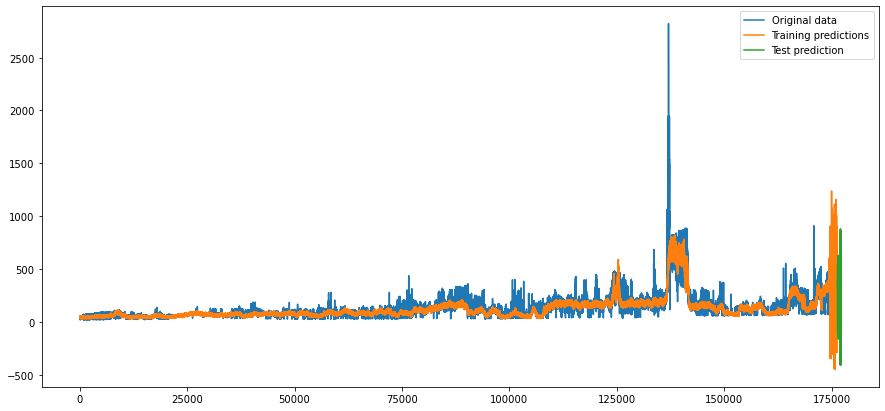

In [31]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

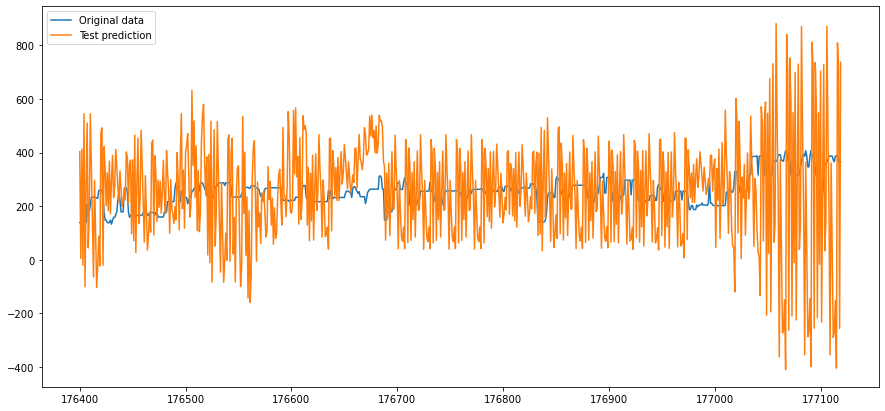

In [32]:
# shift test predictions for plotting
testOriginalPlot = np.zeros((Nt,1))
testOriginalPlot[:, :] = np.nan
testOriginalPlot[len(trainPredict):Nt, :] = testY

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()